# **Description**

SIFT using Bag of visual words and TF-IDF weighing for descriptors.

|SIFT hyperparameter|Tested|Best|
|---|---|---|
|`sigma` | [1.6, 5, 10] | 5|
|`n octave layers` | [1,4,5] | 5|
|`contrastThreshold` | [0.03, 0.01] | 0.01|
|`edgeThreshold` | [10,20] | 20|  



Bag of visual words: using k-means clustering. Tried the following number of clusters:
- $\sqrt{numfiles}$
- $2*\sqrt{numfiles}$
- $0.1*{numfiles}$


##Set Up

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import shutil #save images
from tqdm import tqdm #progress bar
import cv2
import matplotlib.pyplot as plt
import math
import random


from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import SIFT, match_descriptors
from skimage.data import camera
from skimage.transform import rotate
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer


from skimage import color, exposure
from sklearn.decomposition import PCA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  36824      0 --:--:-- --:--:-- --:--:-- 36930
OK
2 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 ne

In [ ]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1722179636,"nanos":453505993},"severity":"INFO","message":"Start gcsfuse/2.3.2 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1722179636,"nanos":453778822},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"MaxRetryDuration\":-1000000000,\"RetryMultiplier

In [ ]:
#check mounting
os.listdir(local_path)

['feature_matrices',
 'features',
 'predictions',
 'raw-data',
 'test_data_preprocessed',
 'train_data_preprocessed',
 'validation_data_preprocessed',
 'weights']

##Specify input & create output directory

In [ ]:
#specifiy input image folder
input_path = os.path.join(local_path, 'train_data_preprocessed')

# Create output directory if it doesn't exist
output_path = os.path.join(local_path, 'features')
os.makedirs(output_path, exist_ok=True)

#test makedir
os.listdir(f"{local_path}")

['feature_matrices',
 'features',
 'predictions',
 'raw-data',
 'test_data_preprocessed',
 'train_data_preprocessed',
 'validation_data_preprocessed',
 'weights']

In [ ]:
input_files = os.listdir(input_path)
print("Number of Images: ", len(input_files))
print("Sample file name: ", input_files[0])

Number of Images:  6254
Sample file name:  A01_02260289.JPG


## Helper functions

In [ ]:
# SIFT
def extract_sift_features(img, sift):
    keypoints, descriptor = sift.detectAndCompute(img, None)
    return keypoints, descriptor

In [ ]:
# BOVW
def create_bovw_histogram(descriptor, kmeans):
    if descriptor is None or descriptor.shape[0] == 0:
        return np.zeros(kmeans.n_clusters)
    words = kmeans.predict(descriptor)
    histogram, _ = np.histogram(words, bins=kmeans.n_clusters, range=(0, kmeans.n_clusters))
    return histogram

In [ ]:
# Select 10% of the images for sampling
all_files = os.listdir(input_path)
num_files_to_process = max(1, int(len(all_files) * 0.1))
selected_files = random.sample(all_files, num_files_to_process)

In [ ]:
num_visualizations = min(10, len(all_files)) #change to all_files in training
visualization_files = random.sample(all_files, num_visualizations)  #change to all_files in training
visualization_files

['N19_101EK113_05250034.JPG',
 'N00_100EK113_05040755.JPG',
 'N20_100EK113_01160328.JPG',
 'M01_101EK113_03280516.JPG',
 'N19_100EK113_04020624.JPG',
 'N29_102EK113_03200897.JPG',
 'N10_100EK113_06290961.JPG',
 'N04_100EK113_01290266.JPG',
 'N29_105EK113_04110968.JPG',
 'N04_101EK113_04300372.JPG']

In [ ]:
# Find species name for visualization files in order to add a label using train_downsampled.csv file for label
image_labels = pd.read_csv('/content/drive/MyDrive/w281_Project/0_data/train_downsampled.csv')

# subset only common_name and filename_new from image_labels for all filename_new in visualization_files
common_names = image_labels[image_labels['filename_new'].isin(visualization_files)][['filename_new','common_name']]
common_names



,filename_new,common_name
550,N29_105EK113_04110968.JPG,Peccary
614,N10_100EK113_06290961.JPG,Peccary
841,N20_100EK113_01160328.JPG,Peccary
1073,M01_101EK113_03280516.JPG,Peccary
1500,N19_100EK113_04020624.JPG,Black Agouti
2165,N29_102EK113_03200897.JPG,Spotted Paca
2821,N04_100EK113_01290266.JPG,Spotted Paca
3047,N04_101EK113_04300372.JPG,Spotted Paca
3517,N19_101EK113_05250034.JPG,Dasypus Species
4338,N00_100EK113_05040755.JPG,South American Coati


## Preprocessing + SIFT

In [ ]:
# clahe and sift set-up
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
sift = cv2.SIFT_create(nOctaveLayers=5, sigma=5, contrastThreshold=0.01, edgeThreshold=20) #sigma 3, noctave 5, contrastThreshold=0.01

In [ ]:
# Extract SIFT features
all_descriptors = []
for file in tqdm(all_files, desc="Extracting SIFT features"):
    img = cv2.imread(f"{input_path}/{file}")
    img = rgb2gray(img)
    img = rescale(img, 0.1, anti_aliasing=True)
    img = (img * 255 / img.max()).astype(np.uint8)
    img = clahe.apply(img)
    _, descriptor = extract_sift_features(img, sift)
    if descriptor is not None and descriptor.shape[0] > 0:
        all_descriptors.extend(descriptor)

# Combine all descriptors
all_descriptors = np.array(all_descriptors)

Extracting SIFT features: 100%|██████████| 6254/6254 [37:14<00:00,  2.80it/s]


## BOVW with K-means



In [ ]:
# Define number of clusters for k-means
num_clusters =  int(math.sqrt(len(all_files)))  #rule of thumb is sqrt of num images
print(f'Number of clusters: {num_clusters}, and number of input files: {len(all_files)}')

# Fit k-means model to descriptors
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(all_descriptors)

# Define visual vocabulary
vocabulary = kmeans.cluster_centers_

Number of clusters: 79, and number of input files: 6254


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Create BOVW histograms

In [ ]:
feature_bovw_tfidf = {}

bovw_features = []
file_names = []

for file in tqdm(all_files, desc="Creating BoVW histograms"):
    img = cv2.imread(f"{input_path}/{file}")
    img = rgb2gray(img)
    img = rescale(img, 0.1, anti_aliasing=True)
    img = (img * 255 / img.max()).astype(np.uint8)
    img = clahe.apply(img)
    _, descriptor = extract_sift_features(img, sift)
    histogram = create_bovw_histogram(descriptor, kmeans)
    bovw_features.append(histogram)
    file_names.append(file)

bovw_features = np.array(bovw_features)

# Apply TF-IDF weighting
tfidf_transformer = TfidfTransformer()
bovw_features_tfidf = tfidf_transformer.fit_transform(bovw_features).toarray()

# Create dictionary with file names as keys and TF-IDF weighted features as values
for file, feature in zip(file_names, bovw_features_tfidf):
    feature_bovw_tfidf[file] = feature

Creating BoVW histograms: 100%|██████████| 6254/6254 [23:18<00:00,  4.47it/s]


# Visualization

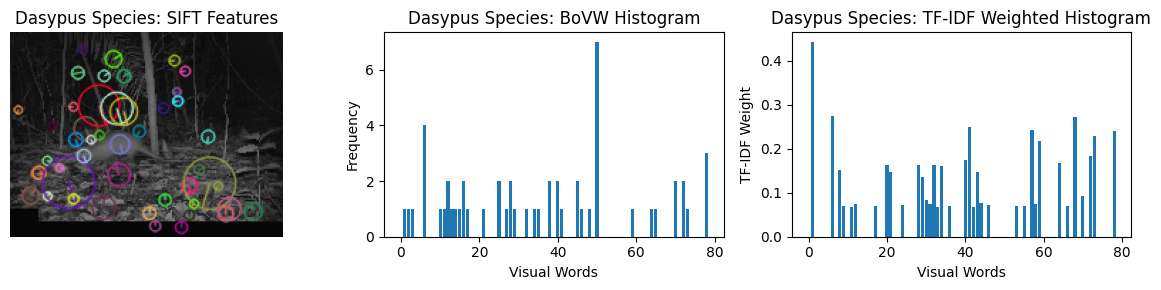

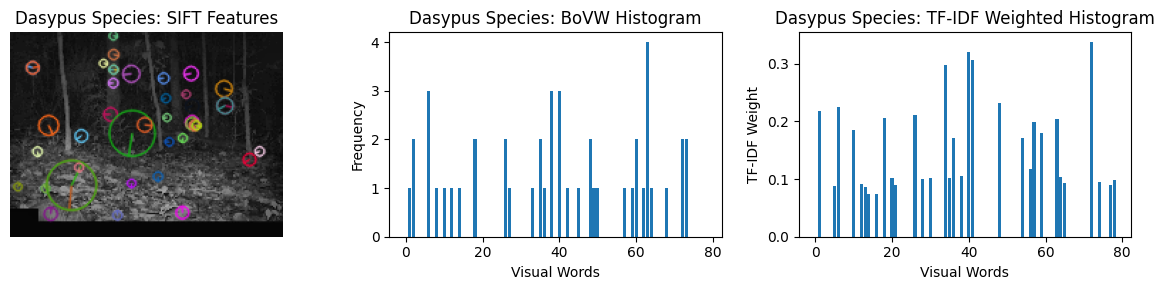

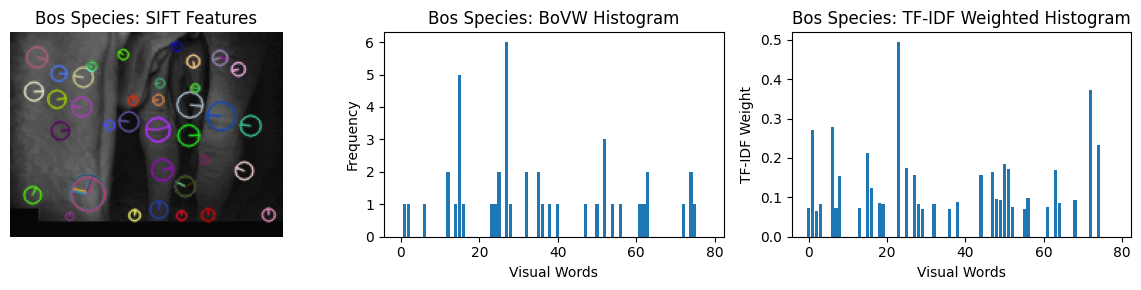

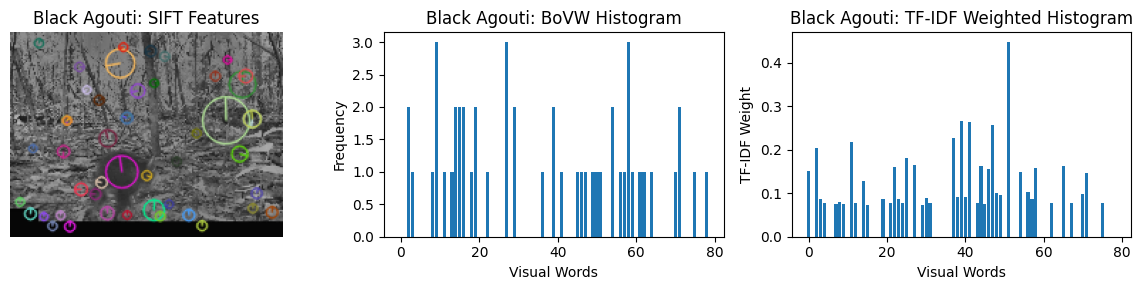

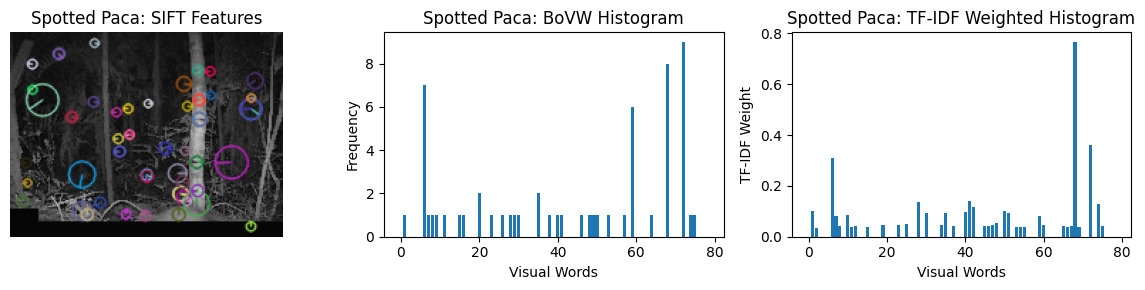

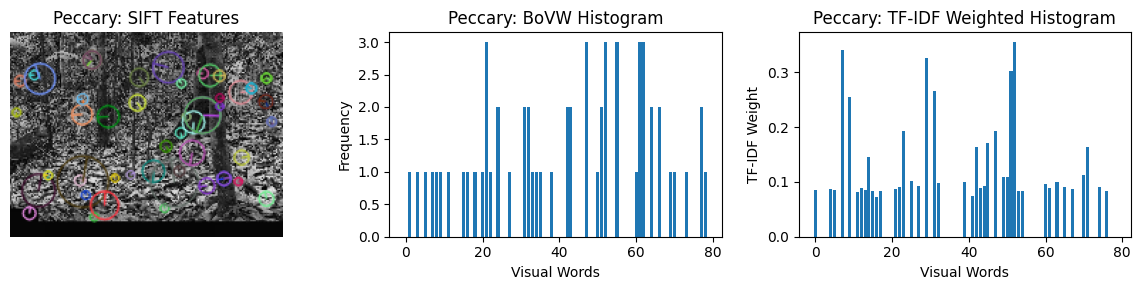

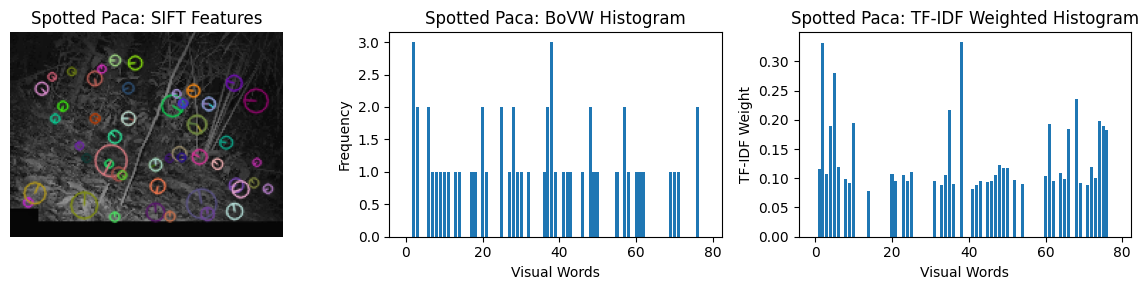

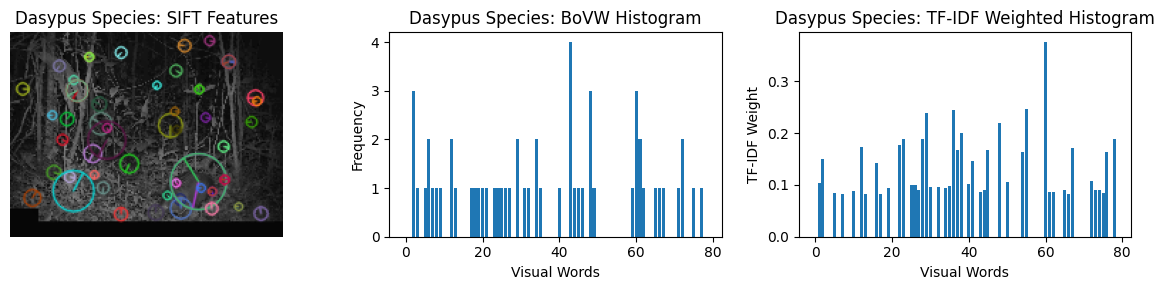

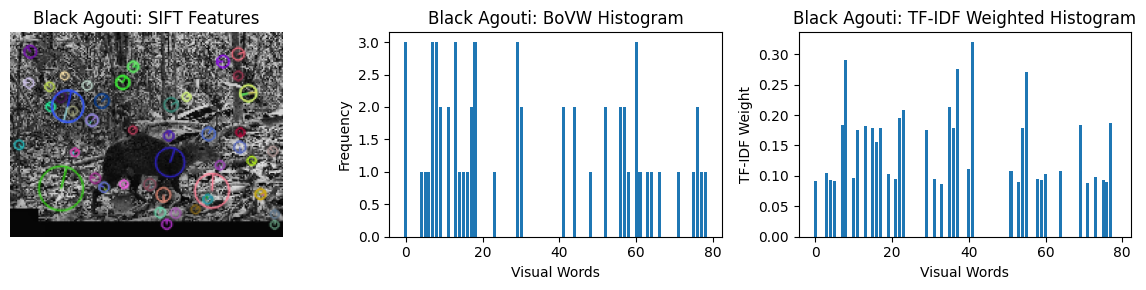

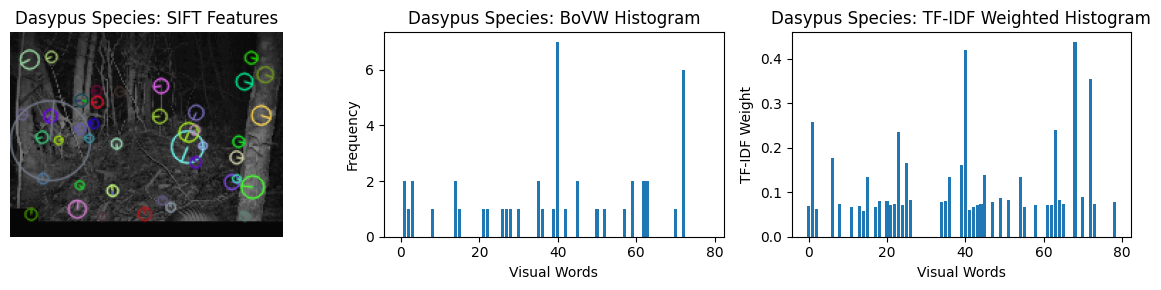

In [ ]:
num_visualizations = min(10, len(feature_bovw_tfidf))
visualization_files = random.sample(list(feature_bovw_tfidf.keys()), num_visualizations)

for file in visualization_files:
    # Find species name for visualization files in order to add a label using train_downsampled.csv file for label
    image_labels = pd.read_csv('/content/drive/MyDrive/w281_Project/0_data/train_downsampled.csv')
    common_name = image_labels[image_labels['filename_new'] == file]['common_name'].values
    common_name = common_name[0]

    img = cv2.imread(f"{input_path}/{file}", cv2.IMREAD_GRAYSCALE)
    img_lr = cv2.resize(img, (0,0), fx=0.1, fy=0.1)
    img_clh = clahe.apply(img_lr.astype(np.uint8))

    keypoints, descriptor = extract_sift_features(img_clh, sift)
    bovw_histogram = create_bovw_histogram(descriptor, kmeans)
    tfidf_histogram = feature_bovw_tfidf[file]

    plt.figure(figsize=(20, 3))

    # # Original Image
    # plt.subplot(151)
    # plt.imshow(img, cmap='gray')
    # plt.title(f'Original Image: {common_name}')
    # plt.axis('off')

    # # Low-res Image
    # plt.subplot(152)
    # plt.imshow(img_lr, cmap='gray')
    # plt.title(f'Low-res Image: {common_name}')
    # plt.axis('off')

    # SIFT Features
    plt.subplot(151)
    img_with_keypoints = cv2.drawKeypoints(img_clh, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_with_keypoints)
    plt.title(f'{common_name}: SIFT Features')
    plt.axis('off')

    # BoVW Histogram
    plt.subplot(152)
    plt.bar(range(len(bovw_histogram)), bovw_histogram)
    plt.title(f'{common_name}: BoVW Histogram')
    plt.xlabel('Visual Words')
    plt.ylabel('Frequency')

    # TF-IDF Weighted Histogram
    plt.subplot(153)
    plt.bar(range(len(tfidf_histogram)), tfidf_histogram)
    plt.title(f'{common_name}: TF-IDF Weighted Histogram')
    plt.xlabel('Visual Words')
    plt.ylabel('TF-IDF Weight')

    plt.tight_layout()
    plt.show()